# Project Graham

**Intro (Model-ception):**
  Mapping dynamics of the brain is pretty complex. What if we could a try and model a smaller target? What if we could model dynamics
of a brain organoid? It's a model of a model, and this is the idea behind Project Graham.

**Background on Organoids:**
  Organoids are these neat little clusters of neurons derived from stem cells. We can use them for a variety of things,
    including modeling brain development, disease, and even drug testing. Wouldn't it be cool if we could model
    and predict dynamics? Maybe even eliminate the need for some experiments and save money?

**The Goal:** 
  The goal of Graham is to utilize spiking neural networks to model bursting dynamics of an organoid. 

**Project Plan:**
  1. Gather Data - We will use curated data generated from the Sharf Lab at UCSC
  2. Develop methods for quantifying bursting dynamics
  2. Train Non-Spiking and Spiking Model, evaluate performance

**Future Plan:**
  1. Hoping that Spiking Neural Networks will be able to capture the bursting dynamics of the organoid, 
    or provide meaningful performance benefits for sparse spiking data, use this model as a stepping
    stone to model more complex dynamics other than just bursting (i.e. input).
  

---
## Electrophysiology / Data Structure Background

### What is Ephys Data?

Organoids are placed on a multi-electrode array (MEA) and the electrical activity is recorded. This 
data is then processed to extract features like spike times, spike rates, and bursting dynamics.

![well.png](well.png) ![org](org.png)

### What does the data look like? 

Data has already been curated through kilosort, a program to process raw data, which we will train the model on to predict the bursting dynamics of the organoid.


In [2]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

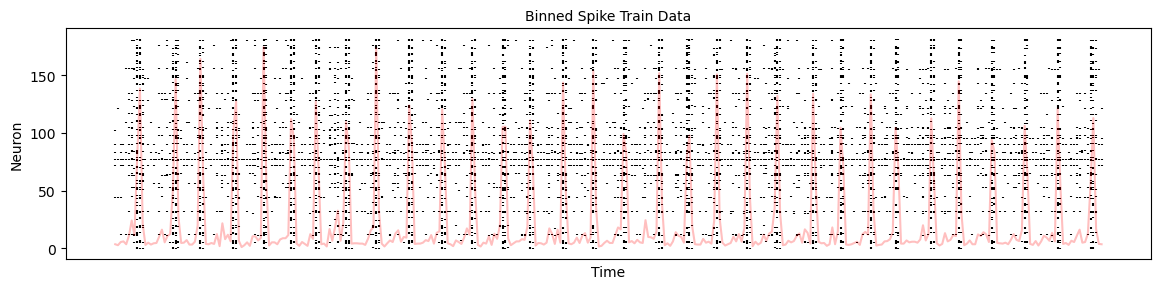

In [3]:
'''
Load in the curated EPhys Data as npz object 
  Data Structure:
    train: 
        Format: {neuron, [associated spike times]}
        Explanation: For each neuron, there is an associated list of spike times
    neuron_data: 
        Format: {neuron, [associated data]}
        Explanation: For each neuron, list of associated data (spatial coordinates, etc.)
    redundant_pairs: literally that
        Format: {neuron, [associated redundant pairs]}
        Explanation: For each neuron, list of associated redundant
    fs: sampling rate
        Format: int
        Explanation: Sampling rate of the data
'''

def convert_to_binned(spike_data, sample_freq, bin_size_ms=500):
    ''' We go over this later with documentation '''
    selected_neurons = list(spike_data.keys())
    max_spike_time = max(max(times) for times in spike_data.values()) if spike_data else 0
    total_time_seconds = max_spike_time / sample_freq
    total_time_ms = total_time_seconds * 1000  # Convert seconds to milliseconds
    num_bins = int(np.ceil(total_time_ms / bin_size_ms))
    num_neurons = len(selected_neurons)
    binned_data = np.zeros((num_bins, num_neurons), dtype=int)
    for neuron_idx, neuron in enumerate(selected_neurons):
        spike_times = np.array(spike_data[neuron])  # Spike times for this neuron
        times_seconds = spike_times / sample_freq
        times_ms = times_seconds * 1000
        bin_indices = (times_ms / bin_size_ms).astype(int)
        valid_indices = (bin_indices >= 0) & (bin_indices < num_bins)
        np.add.at(binned_data[:, neuron_idx], bin_indices[valid_indices], 1)
    return binned_data


# Load data
fname = "data.npz"  # Your data file
data = np.load(fname, allow_pickle=True)
spike_train = data['train'].item()
sample_freq = data['fs']
neuron_data = data['neuron_data'].item()

binned_data = convert_to_binned(spike_train, sample_freq)

# Plot binned data
plt.figure(figsize=(14, 3))
plt.title("Binned Spike Train Data", fontsize=10)
plt.xticks([])
plt.ylabel("Neuron")
plt.xlabel("Time")
y = 0
for i in range(binned_data.shape[1]):
    plt.eventplot(np.where(binned_data[:, i] > 0), lineoffsets=y, linelengths=0.5, colors='black')  
    y += 1

num_firing_neurons = np.sum(binned_data, axis=1)
num_nuerons = binned_data.shape[1]
num_firing_neurons = num_firing_neurons / num_nuerons
plt.plot(num_firing_neurons * 50, color='red', alpha=0.25)

plt.show()

## That's cool and all, but how do we quantify characteristics of the data?

*Note that axies are not correct due to binning*


### Activity per Time Bin

$$
N = \Sigma \text{  (Spikes per Time Bin)} 
$$

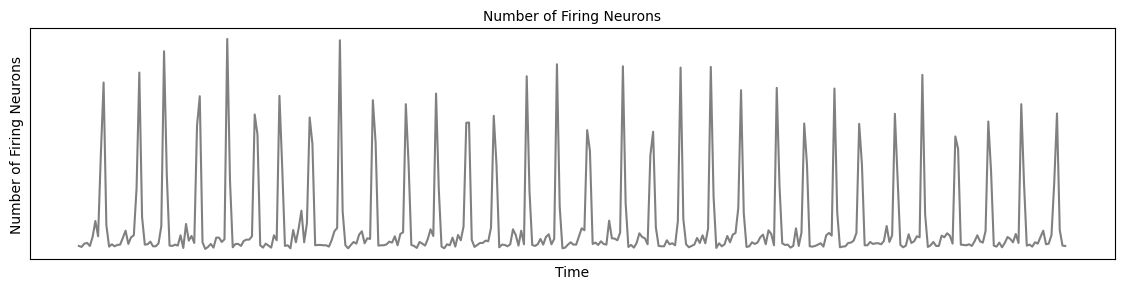

In [4]:
# Get total number of firing neurons at each time step
num_firing_neurons = np.sum(binned_data, axis=1)

# Normalize num_nuerons to original number of neurons
num_firing_neurons = num_firing_neurons

# Plot number of firing neurons
plt.figure(figsize=(14, 3))
plt.title("Number of Firing Neurons", fontsize=10)
plt.plot(num_firing_neurons, color='grey')
plt.xticks([])
plt.yticks([])
plt.ylabel("Number of Firing Neurons")
plt.xlabel("Time")
plt.show()


### Activity Per Neuron

$$
A = \Sigma \text{  (Spikes per Neuron)}
$$

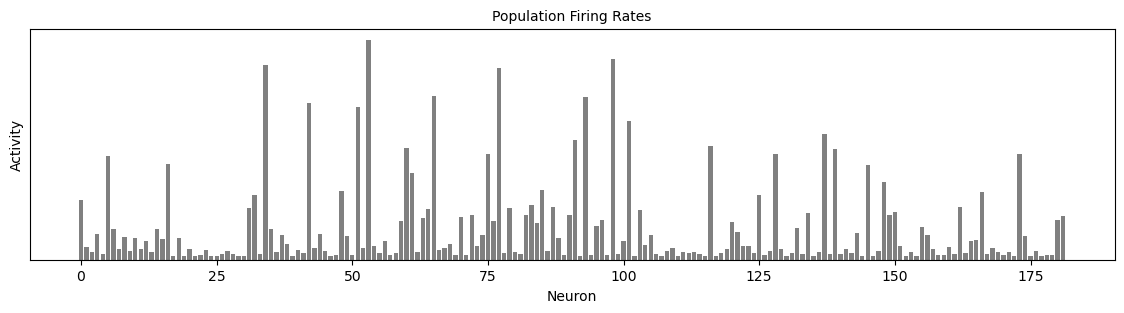

In [8]:
# Neuron Firing Rates
pop_firing_rates = np.sum(binned_data, axis=0)

# Plot population firing rates
plt.figure(figsize=(14, 3))
plt.title("Population Firing Rates", fontsize=10)
plt.xlabel("Neuron")
plt.yticks([])
plt.ylabel("Activity")
plt.bar(np.arange(len(pop_firing_rates)), pop_firing_rates, color='grey')
plt.show()


### ISI Distribution (Inter-Spike Interval)

$$
    \text{Population ISI} = \Sigma (SpikeTime_{i} - SpikeTime_{i-1})
$$

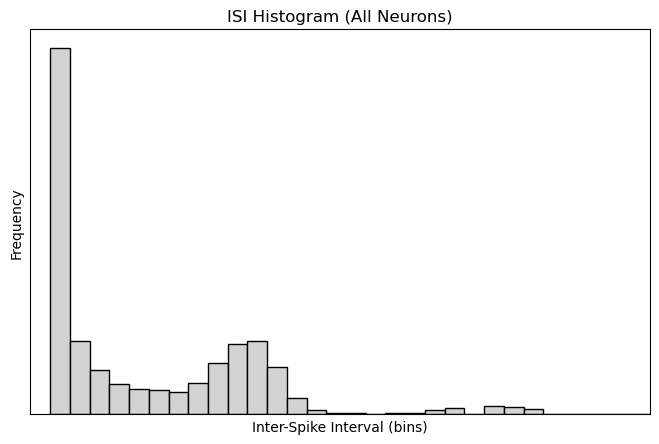

In [9]:
# ISI Distribution

spike_times_per_neuron = [np.where(binned_data[:, neuron] > 0)[0] for neuron in range(binned_data.shape[1])]
isis_per_neuron = [np.diff(spike_times) for spike_times in spike_times_per_neuron if len(spike_times) > 1]
all_isis = np.concatenate(isis_per_neuron)

plt.figure(figsize=(8, 5))
plt.xlim(0, 30)
plt.hist(all_isis, bins=175, edgecolor='k', color='lightgrey')
plt.title('ISI Histogram (All Neurons)')
plt.xlabel('Inter-Spike Interval (bins)')
plt.ylabel('Frequency')
plt.xticks([])
plt.yticks([])
plt.show()

### Population Sparsity Map

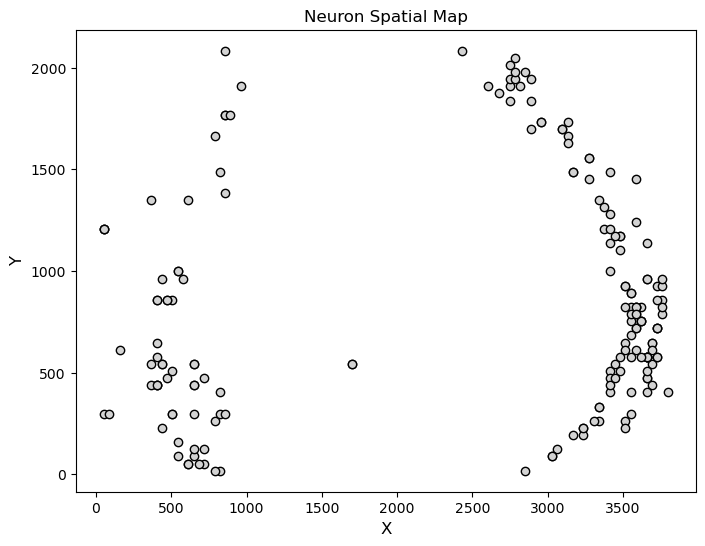

In [ ]:
neuron_x = []
neuron_y = []
for neuron in neuron_data.values():
    neuron_x.append(neuron['position'][0])
    neuron_y.append(neuron['position'][1])
plt.figure(figsize=(8, 6))
plt.scatter(neuron_x, neuron_y, color='lightgrey', edgecolor='black')
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)
plt.title("Neuron Spatial Map")
plt.show()

---
## Neat. Now let's create a model to predict bursting dynamics

### Some Ideas we're going to implement:
1. Let's make the model have the same number of neurons as the organoid for input and output
2. Use higher dimensional layers to capture the dynamics of the data
3. Let's Bin the data, otherwise at 20kHz, we're going to have a lot of data to process for a 5 minute recording


In [8]:
# Bin the data!
# We loose some temporal resolution, but we can still see the general trends
# 20khz * 175 seconds * 182 neurons = 637,000,000 data points

NUMBER_OF_NEURONS = 182

def convert_to_binned(spike_data, sample_freq, bin_size_ms=500, keepNeurons=NUMBER_OF_NEURONS):
    """Convert spike data to binned spike trains.
    
    Args:
        spike_data (dict): Dictionary {neuron: [spike times]}.
        sample_freq (int): Sampling frequency of the spike times.
        bin_size_ms (float): Bin size in milliseconds.
        keepNeurons (int, optional): Number of neurons to keep. If None, use all neurons.
    
    Returns:
        np.ndarray: Binned spike train data (num_bins, num_neurons).
    """
    
    # Determine number of neurons to keep (first `n` neurons)
    all_neurons = list(spike_data.keys())
    if keepNeurons and keepNeurons < len(all_neurons):
        selected_neurons = all_neurons[:keepNeurons]
    else:
        selected_neurons = all_neurons

    # Calculate total time in seconds and convert to bins
    max_spike_time = max(max(times) for times in spike_data.values()) if spike_data else 0
    total_time_seconds = max_spike_time / sample_freq
    total_time_ms = total_time_seconds * 1000
    num_bins = int(np.ceil(total_time_ms / bin_size_ms))
    
    # Create the binned data array
    num_neurons = len(selected_neurons)
    binned_data = np.zeros((num_bins, num_neurons), dtype=int)
    
    # Fill the binned data
    for neuron_idx, neuron in enumerate(selected_neurons):
        spike_times = np.array(spike_data[neuron])
        times_seconds = spike_times / sample_freq
        times_ms = times_seconds * 1000
        bin_indices = (times_ms / bin_size_ms).astype(int)
        valid_indices = (bin_indices >= 0) & (bin_indices < num_bins)
        np.add.at(binned_data[:, neuron_idx], bin_indices[valid_indices], 1)

    return binned_data


In [12]:
# Save the binned data as an object
class SpikeDataClass(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def prepare_data(data, batch_size=32):
    dataset = SpikeDataClass(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# prepare the data
binned_data = convert_to_binned(spike_train, sample_freq)
data_loader = prepare_data(binned_data, batch_size=10)

In [65]:
class TemporalPatternGenerator(nn.Module):
    def __init__(self, num_input=182, num_hidden=256, num_layers=2, dropout=0.9):

        super().__init__()
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_layers = num_layers

        self.pattern_init = nn.Linear(1, num_input)
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(num_input, num_hidden, num_layers, batch_first=True, dropout=dropout)
        # Fully connected output layer
        self.fc_out = nn.Linear(num_hidden, num_input)
        self.activation = nn.ReLU()
        
    def generate(self, num_steps=300, batch_size=1):
        
        
        seed = torch.randn(batch_size, 1)
        current_pattern = self.activation(self.pattern_init(seed))
        
        # Initialize LSTM hidden state
        hidden = (
            torch.zeros(self.num_layers, batch_size, self.num_hidden),
            torch.zeros(self.num_layers, batch_size, self.num_hidden),
        )
        
        patterns = []

        for step in range(num_steps):
            # LSTM processes the current pattern
            lstm_out, hidden = self.lstm(current_pattern.unsqueeze(1), hidden)

            # Generate the next pattern
            current_pattern = self.activation(self.fc_out(lstm_out.squeeze(1)))
            patterns.append(current_pattern)
        
        return torch.stack(patterns, dim=0)

    def forward(self, x):
        # Process temporal sequences (training mode)
        # x has shape: (time_steps, batch_size, num_input)
        lstm_out, _ = self.lstm(x)
        output = self.activation(self.fc_out(lstm_out))
        return output

def train_temporal_pattern_generator(model, data_loader, num_epochs, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in data_loader:
            batch = batch.unsqueeze(0)
            optimizer.zero_grad()
            output = model(batch)
            
            # Pattern reconstruction loss
            recon_loss = criterion(output, batch)
            
            # Time-bin firing rate control
            time_rates = output.mean(dim=2)
            time_loss = torch.mean(torch.relu(time_rates - 0.5)**2)
            
            # Per-neuron rate control
            neuron_rates = output.mean(dim=1)
            rate_loss = torch.mean(torch.relu(neuron_rates - 0.5)**2)
            
            # Inter-spike interval regularization
            isi_loss = torch.mean(torch.abs(output[:, 1:] - output[:, :-1]))
            
            # Population sparsity
            pop_sparsity = torch.mean(torch.abs(output))
            
            # Total loss
            loss = (recon_loss * 10)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(data_loader)
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')
    
    return model

In [68]:
# Usage
model = TemporalPatternGenerator(num_input=binned_data.shape[1], num_hidden=256)
data_loader = prepare_data(binned_data, batch_size=10)

model = train_temporal_pattern_generator(model, data_loader, num_epochs=20)
generated_data = model.generate(num_steps=binned_data.shape[0])

Epoch 0, Loss: 28.7994
Epoch 1, Loss: 23.6968
Epoch 2, Loss: 15.9237
Epoch 3, Loss: 13.2632
Epoch 4, Loss: 12.0277
Epoch 5, Loss: 11.2661
Epoch 6, Loss: 11.7587
Epoch 7, Loss: 12.0101
Epoch 8, Loss: 11.4244
Epoch 9, Loss: 11.9199
Epoch 10, Loss: 11.7245
Epoch 11, Loss: 12.1195
Epoch 12, Loss: 11.3273
Epoch 13, Loss: 10.8087
Epoch 14, Loss: 10.6084
Epoch 15, Loss: 11.0853
Epoch 16, Loss: 10.2894
Epoch 17, Loss: 11.3529
Epoch 18, Loss: 10.3950
Epoch 19, Loss: 9.6954


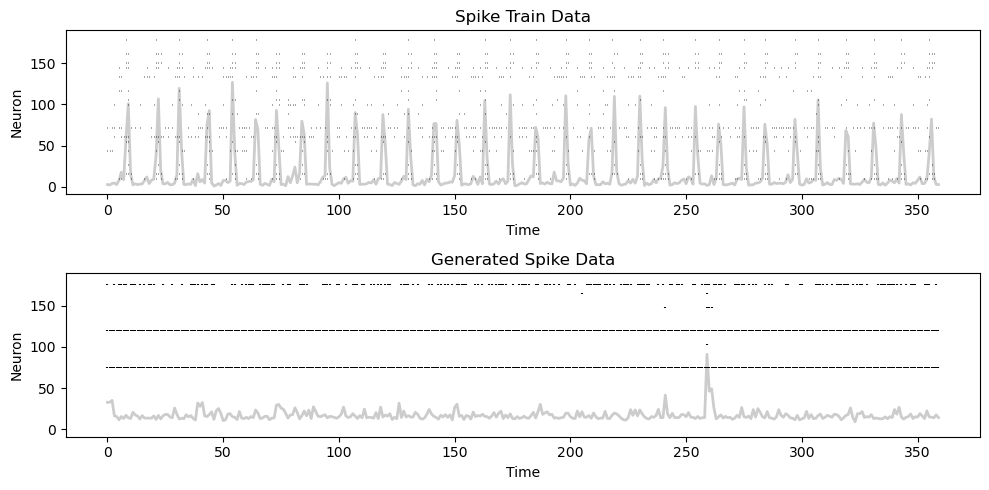

In [69]:
# Well, let's hope it worked and plot the data

# Remove time dimension for plotting
generated_data = generated_data.squeeze().detach().numpy()

# Plot training data
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)  # First subplot for spike trains
plt.title("Spike Train Data")
plt.xlabel("Time")
plt.ylabel("Neuron")
y_offset = 0
for i in range(binned_data.shape[1]):
    plt.eventplot(np.where(binned_data[:, i] > 0)[0], lineoffsets=y_offset, linelengths=0.1, colors='black', linewidths=0.5)
    y_offset += 1 
plt.plot(np.sum(binned_data, axis=1) * .2, color='black', linewidth=2, alpha=0.2)

# Plot generated spikes
plt.subplot(2, 1, 2)
plt.title("Generated Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron")
y_offset = 0 
for i in range(generated_data.shape[1]):
    plt.eventplot(np.where(generated_data[:, i] > 0)[0], lineoffsets=y_offset, linelengths=0.1, colors='black')
    y_offset += 1
plt.plot(np.sum(generated_data, axis=1), color='black', linewidth=2, alpha=0.2)
plt.tight_layout()
plt.show()


A bit of action, but nowhere near enough.

## Sooooooo... throw an SNN at it and hope it sticks?

Epoch 0, Loss: 0.014842595905065536
Epoch 1, Loss: 0.02250528335571289
Epoch 2, Loss: 0.007477122824639082
Epoch 3, Loss: 0.01114539336413145
Epoch 4, Loss: 0.06949346512556076
Epoch 5, Loss: 0.014050805941224098
Epoch 6, Loss: 0.003618457354605198
Epoch 7, Loss: 0.08365573734045029
Epoch 8, Loss: 0.19556434452533722
Epoch 9, Loss: 0.0023939842358231544
Epoch 10, Loss: 0.30197015404701233
Epoch 11, Loss: 0.1850471943616867
Epoch 12, Loss: 0.1467393934726715
Epoch 13, Loss: 0.0010394443525001407
Epoch 14, Loss: 0.04795586317777634
Epoch 15, Loss: 0.2519693374633789
Epoch 16, Loss: 0.02893759496510029
Epoch 17, Loss: 0.16623643040657043
Epoch 18, Loss: 0.006325289607048035
Epoch 19, Loss: 0.03786294534802437
Epoch 20, Loss: 0.07490739971399307
Epoch 21, Loss: 0.13590165972709656
Epoch 22, Loss: 0.06208713725209236
Epoch 23, Loss: 0.11101241409778595
Epoch 24, Loss: 0.1690889298915863
Epoch 25, Loss: 0.06704200059175491
Epoch 26, Loss: 0.2091769278049469
Epoch 27, Loss: 0.1096640080213546

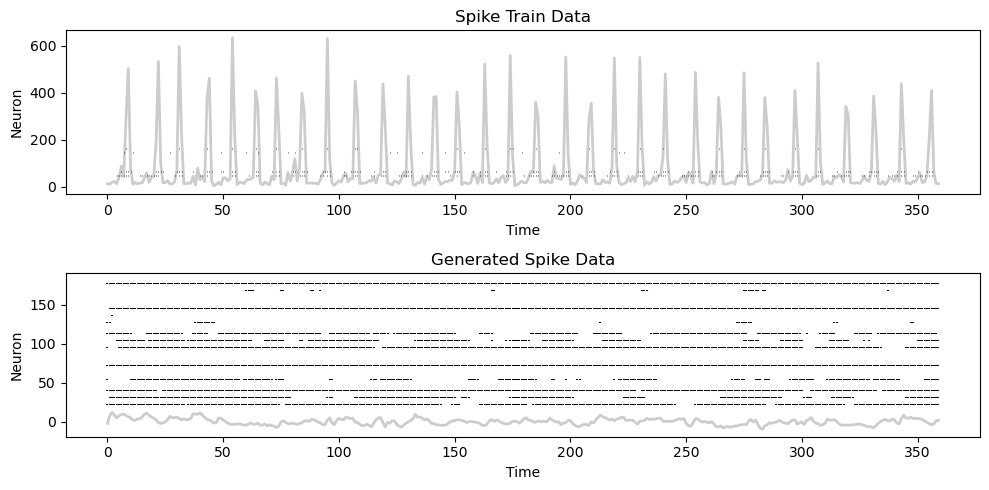

In [76]:
class PatternGenerator(nn.Module):
    def __init__(self, num_input=182, num_hidden=256, beta=0.5, threshold=0.1):
        super().__init__()
        self.num_neurons = num_input
        self.num_hidden = num_hidden
        
        self.pattern_init = nn.Linear(1, num_input)
        self.fc1 = nn.Linear(num_input, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold)
        self.fc2 = nn.Linear(num_hidden, num_input)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold)
        self.fc_recurrent = nn.Linear(num_input, num_input)
        
    def generate(self, num_steps=50, batch_size=1):

        # Generate initial pattern from random seed
        seed = torch.randn(batch_size, 1)
        current_pattern = torch.tanh(self.pattern_init(seed))
        
        membrane1 = self.lif1.init_leaky()
        membrane2 = self.lif2.init_leaky()
        
        patterns = []
        for step in range(num_steps):

            # Generate next pattern through SNN
            current1 = self.fc1(current_pattern)
            spike1, membrane1 = self.lif1(current1, membrane1)
            
            current2 = self.fc2(spike1)
            spike2, membrane2 = self.lif2(current2, membrane2)
            
            # Recurrent connection influences next pattern
            recurrent = self.fc_recurrent(spike2) * 5
            current_pattern = torch.tanh(recurrent + current_pattern)
            patterns.append(current_pattern)
            
        return torch.stack(patterns, dim=0)

    def forward(self, x):
        
        sequence = []
        membrane1 = self.lif1.init_leaky()
        membrane2 = self.lif2.init_leaky()
        
        for t in range(x.size(0)):
            current1 = self.fc1(x[t])
            spike1, membrane1 = self.lif1(current1, membrane1)
            current2 = self.fc2(spike1)
            spike2, membrane2 = self.lif2(current2, membrane2)
            sequence.append(spike2)
            
        return torch.stack(sequence, dim=0)
    

def train_pattern_generator(model, data_loader, num_epochs, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in data_loader:
            batch = batch.unsqueeze(0)
            optimizer.zero_grad()
            output = model(batch)

            # MSE Loss between input and output
            loss = criterion(output, batch)

            target_pop = batch.mean(dim=2)  # Target population rate
            output_pop = output.mean(dim=2)  # Generated population rate
            
            # MSE Loss between target and output population rates
            pop_loss = criterion(output_pop, target_pop)
            
            # Sparse loss
            sparse_loss = torch.mean(torch.abs(output))
            max_rate_loss = torch.mean(torch.relu(output.mean(dim=0) - 0.3))

            # Combine losses
            total_loss = loss + sparse_loss + pop_loss + max_rate_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch}, Loss: {total_loss/len(data_loader)}')
            
    return model

# Usage
model = PatternGenerator(num_input=binned_data.shape[1], num_hidden=256)
data_loader = prepare_data(binned_data, batch_size=3)
model = train_pattern_generator(model, data_loader, num_epochs=100)
generated_data = model.generate(num_steps=binned_data.shape[0])

# Remove time dimension
generated_data = generated_data.squeeze().detach().numpy()

# Plot training data
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title("Spike Train Data")
plt.xlabel("Time")
plt.ylabel("Neuron")
y_offset = 0 
for i in range(binned_data.shape[1]): 
    plt.eventplot(np.where(binned_data[:, i] > 0)[0], lineoffsets=y_offset, linelengths=0.1, colors='black', linewidths=0.5)
    y_offset += 1 
plt.plot(np.sum(binned_data, axis=1), color='black', linewidth=2, alpha=0.2)

# Plot generated spikes
plt.subplot(2, 1, 2)
plt.title("Generated Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron")
y_offset = 0 
for i in range(generated_data.shape[1]):
    plt.eventplot(np.where(generated_data[:, i] > 0)[0], lineoffsets=y_offset, linelengths=0.1, colors='black')
    y_offset += 1
plt.plot(np.sum(generated_data, axis=1), color='black', linewidth=2, alpha=0.2)
plt.tight_layout()
plt.show()

maybe a little better, but well within error of random spiking that I'm seeing (qualitatively)


## Last ditch effort: Autoencoder

In [10]:
class SimpleAutoencoder(nn.Module):
    '''
    Autoencoder with a single linear layer in the encoder and decoder.

    The encoder maps input data to a latent space representation, 
    and the decoder maps the latent space representation back to 
    the original input space. Generative model.
    '''

    def __init__(self, input_dim, latent_dim, threshold=0.5):
        super().__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        self.sigmoid = nn.Sigmoid()
        self.threshold = threshold
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        latent = self.encoder(x)
        reconstruction = self.sigmoid(self.decoder(latent))
        if not self.training:
            reconstruction = (reconstruction > self.threshold).float()
        return reconstruction, latent

def train_simple_autoencoder(model, train_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.view(batch.size(0), -1)
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.6f}')

def tensor_to_spike_times(tensor, freq=20000):
    spike_times = []
    for neuron_idx in range(tensor.size(1)):
        spike_indices = torch.nonzero(tensor[:, neuron_idx]).squeeze()
        spike_times.append(spike_indices.float()/freq)
    return spike_times
    
# Normalize the binned data to range [0, 1]
def normalize_binned_data(binned_data):
    max_value = binned_data.max()
    return binned_data / max_value if max_value > 0 else binned_data

# Function to generate spike trains
def generate_spike_trains(model, num_samples, latent_dim, threshold=.9):
    """
    Generate spike trains using the decoder of a trained autoencoder model.

    Args:
        model (SimpleAutoencoder): The trained autoencoder model.
        num_samples (int): Number of spike trains to generate.
        latent_dim (int): Dimensionality of the latent space.
        threshold (float): Threshold for binarizing the output spike trains.

    Returns:
        torch.Tensor: Generated spike trains.
    """
    model.eval()  # Set the model to evaluation mode

    # Randomly sample latent space vectors
    latent_samples = torch.randn(num_samples, latent_dim)
    
    # Pass through the decoder
    with torch.no_grad(): 
        decoded_output = model.decoder(latent_samples)  # Decode latent samples
    
    # Apply sigmoid activation to get values in [0, 1]
    spike_probabilities = torch.sigmoid(decoded_output)
    
    # Binarize the output using the specified threshold
    generated_spikes = (spike_probabilities > threshold).float()

    return generated_spikes


NUMBER_OF_NEURONS = 182

def convert_to_binned(spike_data, sample_freq, bin_size_ms=500, keepNeurons=NUMBER_OF_NEURONS):

    
    # Determine number of neurons to keep (first `n` neurons)
    all_neurons = list(spike_data.keys())
    if keepNeurons and keepNeurons < len(all_neurons):
        selected_neurons = all_neurons[:keepNeurons]
    else:
        selected_neurons = all_neurons

    # Calculate total time in seconds and convert to bins
    max_spike_time = max(max(times) for times in spike_data.values()) if spike_data else 0
    total_time_seconds = max_spike_time / sample_freq
    total_time_ms = total_time_seconds * 1000
    num_bins = int(np.ceil(total_time_ms / bin_size_ms))
    
    # Create the binned data array
    num_neurons = len(selected_neurons)
    binned_data = np.zeros((num_bins, num_neurons), dtype=int)
    
    # Fill the binned data
    for neuron_idx, neuron in enumerate(selected_neurons):
        spike_times = np.array(spike_data[neuron])
        times_seconds = spike_times / sample_freq
        times_ms = times_seconds * 1000
        bin_indices = (times_ms / bin_size_ms).astype(int)
        valid_indices = (bin_indices >= 0) & (bin_indices < num_bins)
        np.add.at(binned_data[:, neuron_idx], bin_indices[valid_indices], 1)

    return binned_data

# Save the binned data as an object
class SpikeDataClass(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def prepare_data(data, batch_size=32):
    dataset = SpikeDataClass(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


fname = "data.npz"
data = np.load(fname, allow_pickle=True)
spike_train = data['train'].item()
sample_freq = data['fs']

# prepare the data
binned_data = convert_to_binned(spike_train, sample_freq)
normalized_binned_data = normalize_binned_data(binned_data)
data_loader = prepare_data(normalized_binned_data, batch_size=10)
print(normalized_binned_data.data.shape)

# Train model
input_dim = normalized_binned_data.shape[1]
latent_dim = 200
model = SimpleAutoencoder(input_dim, latent_dim)
train_simple_autoencoder(model, data_loader)

generated_spike_trains = generate_spike_trains(model, binned_data.shape[0], latent_dim)

(360, 182)
Epoch 1, Loss: 0.550074
Epoch 2, Loss: 0.258594
Epoch 3, Loss: 0.121949
Epoch 4, Loss: 0.079367
Epoch 5, Loss: 0.069442
Epoch 6, Loss: 0.065990
Epoch 7, Loss: 0.064184
Epoch 8, Loss: 0.062787
Epoch 9, Loss: 0.062021
Epoch 10, Loss: 0.061268
Epoch 11, Loss: 0.060788
Epoch 12, Loss: 0.061277
Epoch 13, Loss: 0.059799
Epoch 14, Loss: 0.059461
Epoch 15, Loss: 0.059120
Epoch 16, Loss: 0.058839
Epoch 17, Loss: 0.058659
Epoch 18, Loss: 0.058393
Epoch 19, Loss: 0.058248
Epoch 20, Loss: 0.057894
Epoch 21, Loss: 0.057688
Epoch 22, Loss: 0.057543
Epoch 23, Loss: 0.057445
Epoch 24, Loss: 0.057174
Epoch 25, Loss: 0.056987
Epoch 26, Loss: 0.056820
Epoch 27, Loss: 0.056715
Epoch 28, Loss: 0.056512
Epoch 29, Loss: 0.056364
Epoch 30, Loss: 0.056259
Epoch 31, Loss: 0.056409
Epoch 32, Loss: 0.055974
Epoch 33, Loss: 0.055862
Epoch 34, Loss: 0.055725
Epoch 35, Loss: 0.055682
Epoch 36, Loss: 0.055513
Epoch 37, Loss: 0.055403
Epoch 38, Loss: 0.055320
Epoch 39, Loss: 0.055224
Epoch 40, Loss: 0.05510

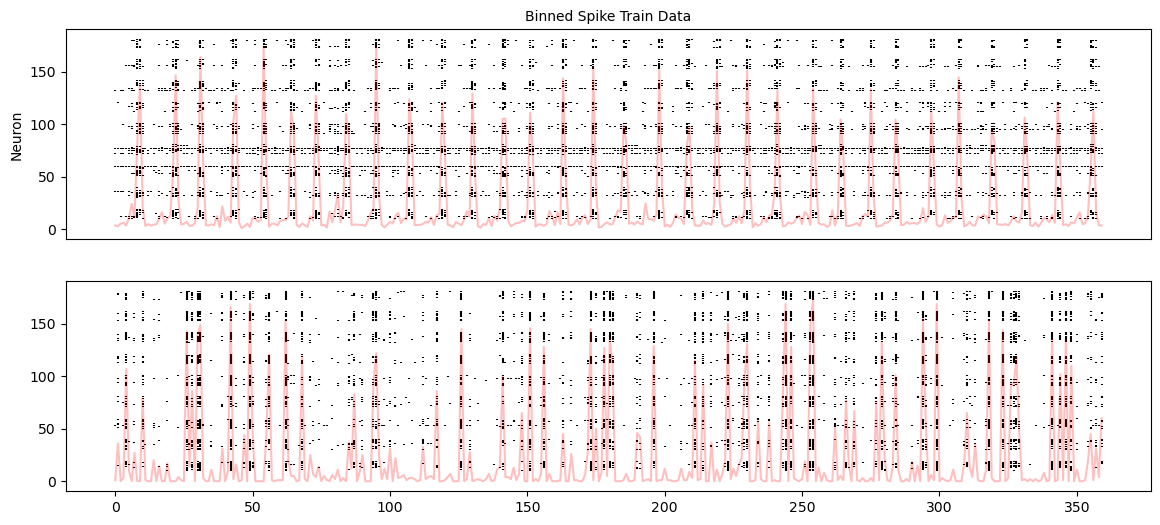

In [11]:
# Plot the generated spike trains
generated_spike_times = tensor_to_spike_times(generated_spike_trains)

# Plot binned data
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.title("Binned Spike Train Data", fontsize=10)
plt.xticks([])
plt.ylabel("Neuron")
y = 0
for i in range(binned_data.shape[1]):
    plt.eventplot(np.where(binned_data[:, i] > 0), lineoffsets=y, linelengths=0.5, colors='black')  
    y += 1
num_firing_neurons = np.sum(binned_data, axis=1)
num_nuerons = binned_data.shape[1]
num_firing_neurons = num_firing_neurons / num_nuerons
plt.plot(num_firing_neurons * 50, color='red', alpha=0.25)

# Plot generated spike trains
plt.subplot(2, 1, 2)
y = 0
for i in range(generated_spike_trains.shape[1]):
    plt.eventplot(np.where(generated_spike_trains[:, i] > 0), lineoffsets=y, linelengths=0.5, colors='black')
    y += 1

summed_activity = generated_spike_trains.sum(dim=1)
plt.plot(summed_activity, color='red', alpha=0.25)
plt.show()

### Yes it's kinda better, but it's *cheating*


# Yeah... So my plan didn't work - what happened?

**Loss Functions**

Pretty visible from the calculated loss at each step. The loss function was not able to converge to a minimum, and the model was not able to learn the dynamics of the data. When it did, it was often just all zeros or continual spiking of one or two neurons. This satisfied the loss function, but did not capture the dynamics of the data.

Note: I re-evaluated the non spiking network, and was able to get similar results to the spiking network. Whether that means that the spiking network is easier to train on the temporal data, or that the non-spiking network was not set up as good, I'm not sure. I changed too many variables to make a good comparison.

**I actually started to see some interesting results using 1 neuron, and heavily weighting periodicity penalty (variance of ISI spike frequency and spike durations). Exciting!!! But a little too late.**

----
# tldr: *I Failed*

### (Believe me, not what I wanted, but I learned some cool stuff along the way)
----


## What will I be trying next?

1. Start with one neuron. That will be much easier to debug and understand what's going on.
2. Generate sythetic data to test the model on, thats not as complex as the organoid data nor as long
3. Use a tradition NN to predict the bursting dynamics, and then try to convert it to a SNN to see if it performs better
4. Spatial Components! That's the part I want the most. It may be easier as it's similar to the NMNIST dataset.
4. **Look into more restrictive loss functions, or ways to quantify the loss better for temporal data**
5. Monte Carlo to test if spiking is random or not